In [16]:
# %%
# ==============================================================
# 1. Imports & notebook settings (WebSky kSZ Patchy)
# ==============================================================

import os
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from astropy.io import fits
import pickle
from pathlib import Path

%matplotlib inline
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "axes.titlesize": 0,
    "axes.labelsize": 16,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 16,
    "font.family": "DejaVu Sans",
    "text.usetex": False,           # <-- Keep False
    "mathtext.fontset": "dejavusans"  # or "cm", "stix"})
})

# ------------------------------------------------------------------
# USER SETTINGS
# ------------------------------------------------------------------
BASE_DIR = os.path.expanduser("~/Desktop/Project2/Plots/WebSky_Maps")
FITS_NAME = "ksz_patchy.fits"
FITS_FILE = os.path.join(BASE_DIR, FITS_NAME)

OUT_DIR = os.path.join(BASE_DIR, "output_WebSky_kSZ_patchy")
os.makedirs(OUT_DIR, exist_ok=True)

print(f"Output will be saved to: {OUT_DIR}")

Output will be saved to: /home/swanith/Desktop/Project2/Plots/WebSky_Maps/output_WebSky_kSZ_patchy


In [2]:
# %%
# ==============================================================
# 2. Diagnose FITS structure
# ==============================================================

def diagnose_fits_structure(fname):
    print("\n" + "="*70)
    print(f"DIAGNOSING: {os.path.basename(fname)}")
    print("="*70)
    with fits.open(fname) as hdul:
        print(f"\nHDUs: {len(hdul)}")
        hdul.info()
        for i, hdu in enumerate(hdul):
            print(f"\n--- HDU {i} ({hdu.name}) ---")
            if hasattr(hdu, "header"):
                keys = ['NSIDE','ORDERING','COORDSYS','PIXTYPE','TTYPE1','TUNIT1']
                for k in keys:
                    if k in hdu.header:
                        print(f"  {k}: {hdu.header[k]}")
            if hasattr(hdu, "data") and hdu.data is not None:
                if hasattr(hdu.data, "columns"):
                    print(f"  Columns: {hdu.data.columns.names}")
                else:
                    print(f"  Data shape: {hdu.data.shape}")

if os.path.isfile(FITS_FILE):
    diagnose_fits_structure(FITS_FILE)
else:
    raise FileNotFoundError(f"Cannot find {FITS_FILE}")


DIAGNOSING: ksz_patchy.fits

HDUs: 2
Filename: /home/swanith/Desktop/Project2/Plots/WebSky_Maps/ksz_patchy.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   ()      
  1  BINTABLE      1 BinTableHDU     17   201326592R x 1C   [1E]   

--- HDU 0 (PRIMARY) ---

--- HDU 1 (BINTABLE) ---
  NSIDE: 4096
  ORDERING: NESTED
  COORDSYS: C
  PIXTYPE: HEALPIX
  TTYPE1: SIGNAL
  TUNIT1: 
  Columns: ['SIGNAL']


In [4]:
# %%
# ==============================================================
# 3. Load kSZ Patchy map (NESTED → RING handled later)
# ==============================================================

def load_fits_data(fname):
    with fits.open(fname) as hdul:
        col_name = hdul[1].data.columns.names[0]
        data = hdul[1].data[col_name].flatten()
        hdr = hdul[1].header
        nside = hp.npix2nside(len(data))
        print(f"Loaded {col_name} → NSIDE={nside}, NPIX={len(data)}")
        return data, hdr, col_name

data, hdr, col_name = load_fits_data(FITS_FILE)

Loaded SIGNAL → NSIDE=4096, NPIX=201326592


In [5]:
# %%
# ==============================================================
# 4. Pixel statistics
# ==============================================================

stats = {
    "min":    data.min(),
    "max":    data.max(),
    "mean":   data.mean(),
    "std":    data.std(),
    "median": np.median(data),
    "rms":    np.sqrt(np.mean(data**2))
}

print("\n" + "="*70)
print("STATISTICS (µK)")
print("="*70)
for k, v in stats.items():
    print(f"  {k:8s}: {v:.6e}")


STATISTICS (µK)
  min     : -3.509760e+01
  max     : 3.360904e+01
  mean    : -2.167261e-01
  std     : 6.324877e+00
  median  : -1.818759e-01
  rms     : 6.328597e+00


<Figure size 1600x800 with 0 Axes>

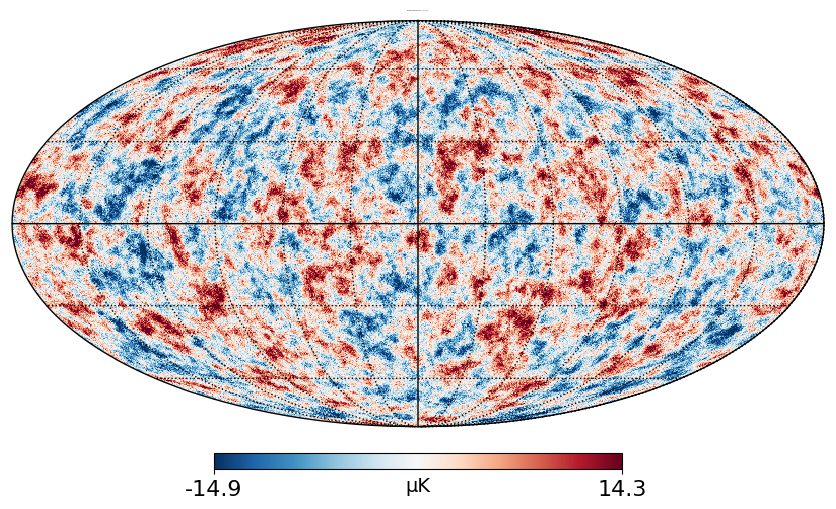

Saved: /home/swanith/Desktop/Project2/Plots/WebSky_Maps/output_WebSky_kSZ_patchy/websky_ksz_patchy_mollweide.pdf


In [18]:
# %%
# ==============================================================
# 5. Mollweide full-sky map (NESTED)
# ==============================================================

vmin, vmax = np.percentile(data, [1, 99])
nside = hp.npix2nside(len(data))

plt.figure(figsize=(16, 8))
hp.mollview(
    data,
    title='WebSky kSZ Patchy – Full Sky',
    unit='µK',
    cmap='RdBu_r',
    min=vmin, max=vmax,
    format='%.1f',
    nest=True  # Critical: NESTED ordering
)
hp.graticule()
ax = plt.gca()
#ax.title.set_fontsize(16)

path = os.path.join(OUT_DIR, "websky_ksz_patchy_mollweide.pdf")
plt.savefig(path, dpi=200, bbox_inches='tight')
plt.show()
print(f"Saved: {path}")


Gaussian overlay: μ = -0.217 µK, σ = 6.325 µK


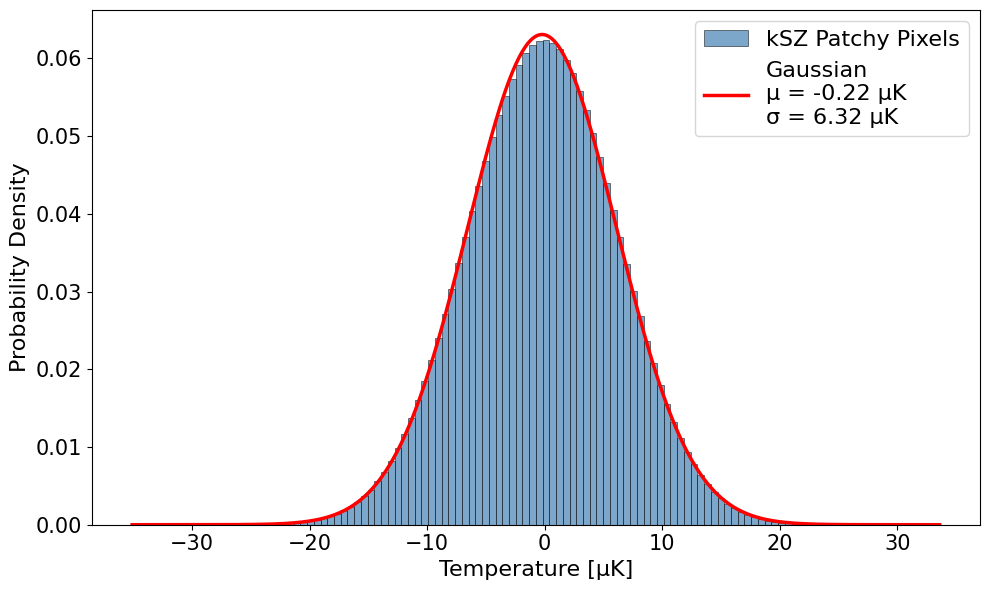

Saved: /home/swanith/Desktop/Project2/Plots/WebSky_Maps/output_WebSky_kSZ_patchy/websky_ksz_patchy_histogram_gaussian.pdf


In [10]:
# %%
# ==============================================================
# 6. Histogram with Gaussian overlay
# ==============================================================

mu = data.mean()
sigma = data.std()
print(f"\nGaussian overlay: μ = {mu:+.3f} µK, σ = {sigma:.3f} µK")

values = data.compressed() if np.ma.is_masked(data) else np.array(data)

plt.figure(figsize=(10, 6))
plt.hist(values, bins=120, density=True, alpha=0.7, color='steelblue',
         edgecolor='black', linewidth=0.5, label='kSZ Patchy Pixels')

x_gauss = np.linspace(values.min(), values.max(), 500)
y_gauss = (1 / (sigma * np.sqrt(2 * np.pi))) * \
          np.exp(-0.5 * ((x_gauss - mu) / sigma)**2)
plt.plot(x_gauss, y_gauss, 'r-', lw=2.5,
         label=f'Gaussian\nμ = {mu:+.2f} µK\nσ = {sigma:.2f} µK')

plt.xlabel('Temperature [µK]', fontsize=16)
plt.ylabel('Probability Density', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=16, frameon=True, fancybox=True, loc='upper right')
plt.tight_layout()

path = os.path.join(OUT_DIR, "websky_ksz_patchy_histogram_gaussian.pdf")
plt.savefig(path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {path}")


Power spectrum: kSZ PATCHY
  → Loading cached C_ℓ


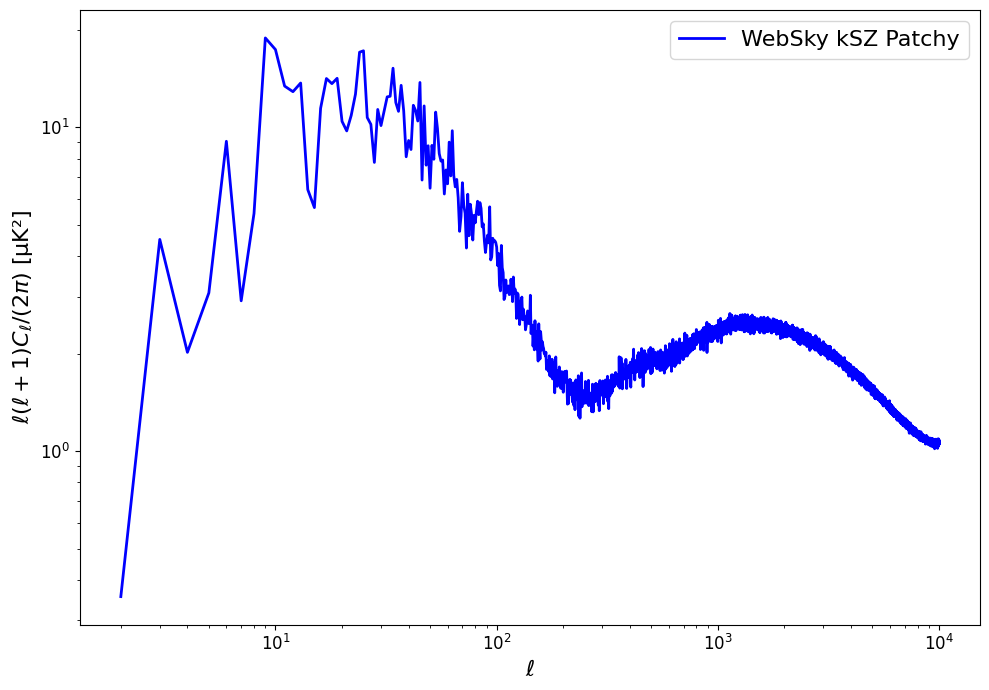

Saved: /home/swanith/Desktop/Project2/Plots/WebSky_Maps/output_WebSky_kSZ_patchy/websky_ksz_patchy_powerspectrum.pdf
Saved data: /home/swanith/Desktop/Project2/Plots/WebSky_Maps/output_WebSky_kSZ_patchy/websky_ksz_patchy_powerspectrum_data.txt


In [14]:
# %%
# ==============================================================
# 7. Power spectrum (cached + NESTED→RING conversion)
# ==============================================================

cache_dir = Path(OUT_DIR) / "cache"
cache_dir.mkdir(exist_ok=True)
cache_file = cache_dir / "websky_ksz_patchy_powerspectrum_cl.pkl"

force_recalculate = False

print("\nPower spectrum: kSZ PATCHY")

if force_recalculate or not cache_file.exists():
    print("  → Converting NESTED → RING for anafast...")
    map_ring = hp.reorder(data, n2r=True)
    lmax = min(3*nside - 1, 10000)
    cl = hp.anafast(map_ring, lmax=lmax)
    ell = np.arange(len(cl))
    with open(cache_file, 'wb') as f:
        pickle.dump(cl, f)
    print(f"  → Cached: {cache_file}")
else:
    print(f"  → Loading cached C_ℓ")
    with open(cache_file, 'rb') as f:
        cl = pickle.load(f)
    ell = np.arange(len(cl))

Dl = ell * (ell + 1) * cl / (2 * np.pi)

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(ell[2:], Dl[2:], 'b-', lw=2, label='WebSky kSZ Patchy')
ax.set_xscale('log'); ax.set_yscale('log')
#ax.set_xlim(10, 10000); ax.set_ylim(1e-4, 10)
ax.set_xlabel(r'$\ell$', fontsize=16)
ax.set_ylabel(r'$\ell(\ell+1) C_\ell / (2\pi)$ [µK²]', fontsize=16)
#ax.set_title('WebSky kSZ Patchy Power Spectrum', fontsize=15)
#ax.grid(True, which='both', alpha=0.3)
ax.legend(); ax.tick_params(labelsize=12)
plt.tight_layout()

ps_path = os.path.join(OUT_DIR, "websky_ksz_patchy_powerspectrum.pdf")
plt.savefig(ps_path, dpi=200, bbox_inches='tight')
plt.show()
print(f"Saved: {ps_path}")

txt_path = os.path.join(OUT_DIR, "websky_ksz_patchy_powerspectrum_data.txt")
np.savetxt(txt_path, np.column_stack([ell, cl, Dl]),
           header='ell  C_ell  D_ell', fmt='%.6e')
print(f"Saved data: {txt_path}")

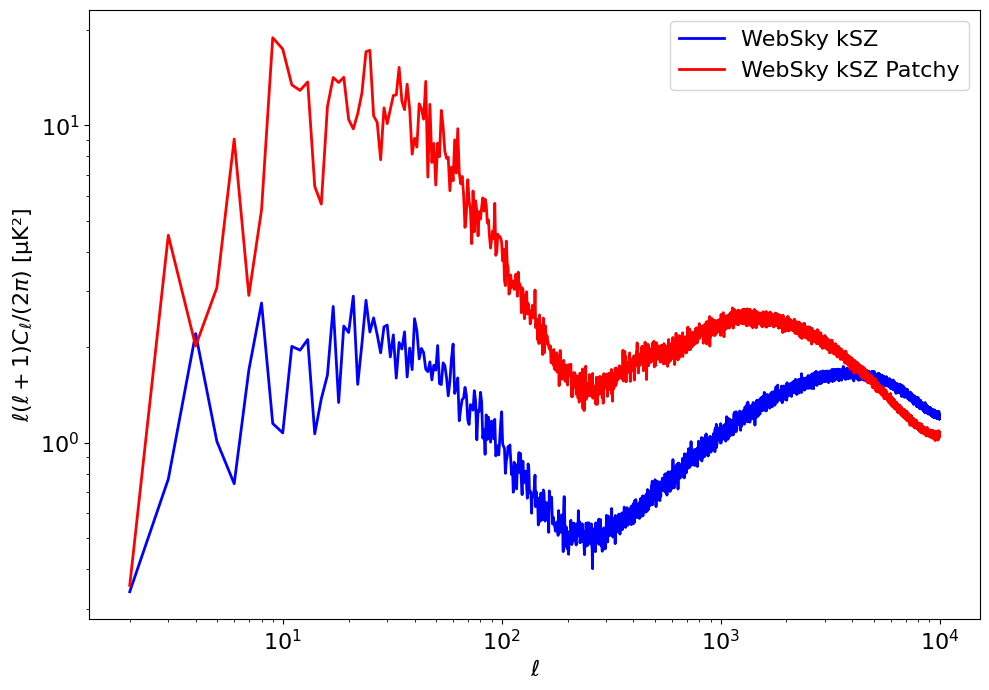

Saved: /home/swanith/Desktop/Project2/Plots/WebSky_Maps/ksz_vs_ksz_patchy_powerspectrum.pdf


In [22]:
# %%
# ==============================================================
# 8. Compare kSZ and kSZ Patchy Power Spectra
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Define paths based on your current directory
BASE_DIR = Path("~/Desktop/Project2/Plots/WebSky_Maps").expanduser()
KSZ_OUT_DIR = BASE_DIR / "output_WebSky_kSZ"
PATCHY_OUT_DIR = BASE_DIR / "output_WebSky_kSZ_patchy"

# Load data files
ksz_file = KSZ_OUT_DIR / "ksz_powerspectrum_data.txt"
patchy_file = PATCHY_OUT_DIR / "websky_ksz_patchy_powerspectrum_data.txt"

if not ksz_file.exists() or not patchy_file.exists():
    print("Error: One or more power spectrum files not found!")
    print(f"  ksz: {ksz_file}")
    print(f"  patchy: {patchy_file}")
else:
    # Load kSZ data
    ksz_data = np.loadtxt(ksz_file, skiprows=1)
    ksz_ell, ksz_cl, ksz_Dl, ksz_Dl_x1e12 = ksz_data.T

    # Load patchy kSZ data
    patchy_data = np.loadtxt(patchy_file, skiprows=1)
    patchy_ell, patchy_cl, patchy_Dl = patchy_data.T

    # Ensure consistent ell range (truncate to shortest)
    min_len = min(len(ksz_ell), len(patchy_ell))
    ksz_ell, ksz_Dl_x1e12 = ksz_ell[:min_len], ksz_Dl_x1e12[:min_len]
    patchy_ell, patchy_Dl = patchy_ell[:min_len], patchy_Dl[:min_len]

    # Plot
    plt.figure(figsize=(10, 7))
    plt.plot(ksz_ell[2:], ksz_Dl_x1e12[2:]*1e-12, 'b-', lw=2, label='WebSky kSZ')
    plt.plot(patchy_ell[2:], patchy_Dl[2:], 'r-', lw=2, label='WebSky kSZ Patchy')

    plt.xscale('log')
    plt.yscale('log')
    #plt.xlim(10, 10000)
    #plt.ylim(1e-4, 10)
    plt.xlabel(r'$\ell$', fontsize=16)
    plt.ylabel(r'$ \ell(\ell+1) C_\ell / (2\pi)$ [µK²]', fontsize=16)
    #plt.title('Comparison: kSZ vs kSZ Patchy Power Spectra', fontsize=15)
    #plt.grid(True, which='both', alpha=0.3)
    plt.legend(fontsize=16)
    plt.tick_params(labelsize=16)
    plt.tight_layout()

    save_path = BASE_DIR / "ksz_vs_ksz_patchy_powerspectrum.pdf"
    plt.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()
    print(f"Saved: {save_path}")